In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 2, kernel_size=3, stride=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.fc1 = nn.Linear(2,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 2)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x, dim=1)

In [198]:
import torch.optim as optim

n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [199]:
from torchsummary import summary
summary(network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
         MaxPool2d-2            [-1, 4, 13, 13]               0
            Conv2d-3              [-1, 2, 4, 4]              74
         MaxPool2d-4              [-1, 2, 1, 1]               0
            Linear-5                   [-1, 10]              30
Total params: 144
Trainable params: 144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [200]:
import torch
import torchvision

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [201]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

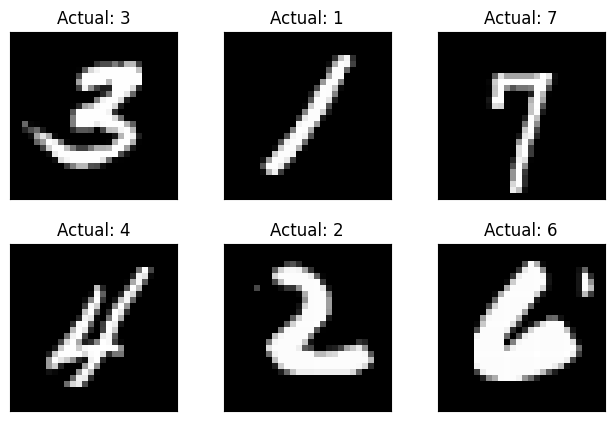

In [202]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Actual: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])


In [203]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [204]:
from math import floor

def train(epoch):
    network.train()
    epoch_loss = 0.0
    total_batches = len(train_loader)
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % log_interval == 0:
            show = 100. * batch_idx / total_batches
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(data), len(train_loader.dataset),
            #     show, loss.item()))

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / total_batches
    train_losses.append(avg_epoch_loss)
    train_counter.append((epoch-1))

    accuracy = 100 * correct / total
    print('Epoch {} completed.\nTrain set: Average Loss: {:.6f}, Accuracy: {:.2f}%'.format(epoch, avg_epoch_loss, accuracy))

    # Save model and optimizer state
    torch.save(network.state_dict(), 'model.pth')
    torch.save(optimizer.state_dict(), 'optimizer.pth')

    return accuracy

In [205]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    
    return accuracy

In [206]:
test_accuracies = []
train_accuracies = []
#accuracies.append(test())
for epoch in range(1, n_epochs + 1):
  train_accuracies.append(train(epoch))
  test_accuracies.append(test())

Epoch 1 completed.
Train set: Average Loss: 2.300381, Accuracy: 11.88%
Test set: Average loss: 2.2766, Accuracy: 1408/10000 (14.08%)

Epoch 2 completed.
Train set: Average Loss: 2.240192, Accuracy: 18.90%
Test set: Average loss: 2.1969, Accuracy: 2017/10000 (20.17%)

Epoch 3 completed.
Train set: Average Loss: 2.185945, Accuracy: 20.27%
Test set: Average loss: 2.1651, Accuracy: 2084/10000 (20.84%)

Epoch 4 completed.
Train set: Average Loss: 2.166061, Accuracy: 21.38%
Test set: Average loss: 2.1513, Accuracy: 2155/10000 (21.55%)

Epoch 5 completed.
Train set: Average Loss: 2.151178, Accuracy: 22.25%
Test set: Average loss: 2.1369, Accuracy: 2283/10000 (22.83%)

Epoch 6 completed.
Train set: Average Loss: 2.138571, Accuracy: 22.80%
Test set: Average loss: 2.1249, Accuracy: 2337/10000 (23.37%)

Epoch 7 completed.
Train set: Average Loss: 2.129344, Accuracy: 23.40%
Test set: Average loss: 2.1200, Accuracy: 2364/10000 (23.64%)

Epoch 8 completed.
Train set: Average Loss: 2.121814, Accuracy

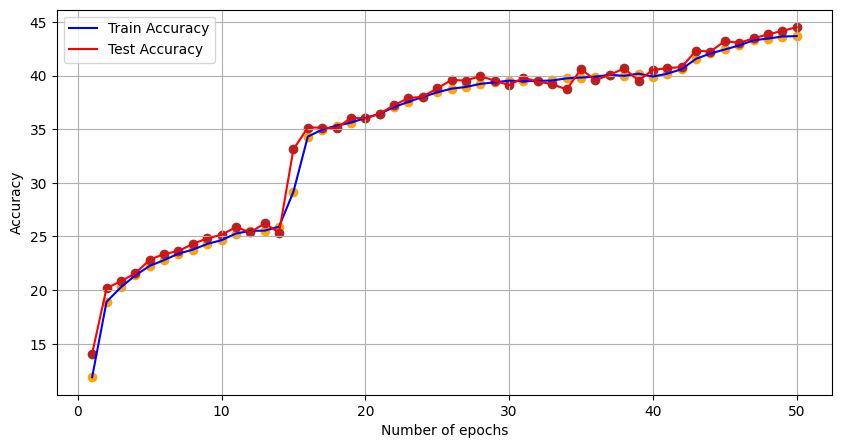

In [207]:
fig = plt.figure(figsize=(10,5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.scatter(epochs, train_accuracies, color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.scatter(epochs, test_accuracies, color='brown')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(visible=True)
plt.show()

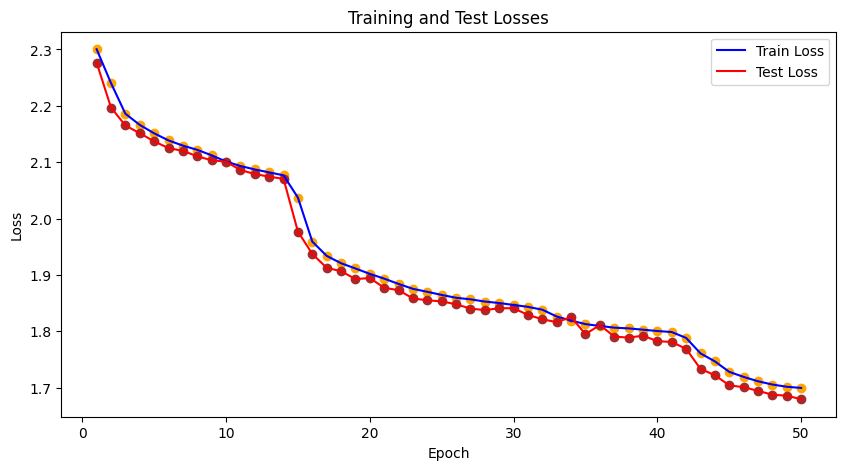

In [208]:
import matplotlib.pyplot as plt

# Plotting train and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.scatter(epochs, train_losses, color='orange')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.scatter(epochs, test_losses, color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()


In [209]:
with torch.no_grad():
  output = network(example_data)

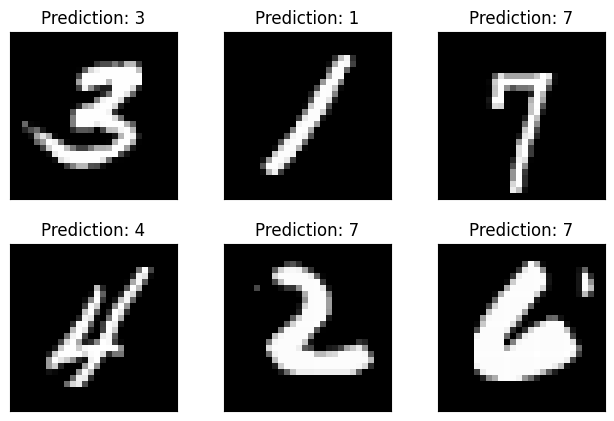

In [210]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [211]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(4, 2, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.fc1 = nn.Linear(8,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 8)
        x = F.relu(self.fc1(x))
        return F.log_softmax(x, dim=1)

In [212]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.1
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [213]:
summary(network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 24, 24]             104
         MaxPool2d-2            [-1, 4, 12, 12]               0
            Conv2d-3              [-1, 2, 8, 8]             202
         MaxPool2d-4              [-1, 2, 2, 2]               0
            Linear-5                   [-1, 10]              90
Total params: 396
Trainable params: 396
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [214]:
train_losses = []
test_losses = []
train_counter = []
test_counter = []

test()

test_accuracies = []
train_accuracies = []
for epoch in range(1, n_epochs + 1):
  train_accuracies.append(train(epoch))
  test_accuracies.append(test())

Test set: Average loss: 2.3228, Accuracy: 931/10000 (9.31%)

Epoch 1 completed.
Train set: Average Loss: 0.883359, Accuracy: 71.89%
Test set: Average loss: 0.6201, Accuracy: 8027/10000 (80.27%)

Epoch 2 completed.
Train set: Average Loss: 0.607429, Accuracy: 80.62%
Test set: Average loss: 0.5424, Accuracy: 8199/10000 (81.99%)

Epoch 3 completed.
Train set: Average Loss: 0.597827, Accuracy: 80.88%
Test set: Average loss: 0.5906, Accuracy: 8073/10000 (80.73%)

Epoch 4 completed.
Train set: Average Loss: 0.590064, Accuracy: 81.02%
Test set: Average loss: 0.6287, Accuracy: 7968/10000 (79.68%)

Epoch 5 completed.
Train set: Average Loss: 0.582917, Accuracy: 81.18%
Test set: Average loss: 0.5199, Accuracy: 8298/10000 (82.98%)

Epoch 6 completed.
Train set: Average Loss: 0.578916, Accuracy: 81.24%
Test set: Average loss: 0.5897, Accuracy: 8168/10000 (81.68%)

Epoch 7 completed.
Train set: Average Loss: 0.578296, Accuracy: 81.31%
Test set: Average loss: 0.5801, Accuracy: 8093/10000 (80.93%)

E

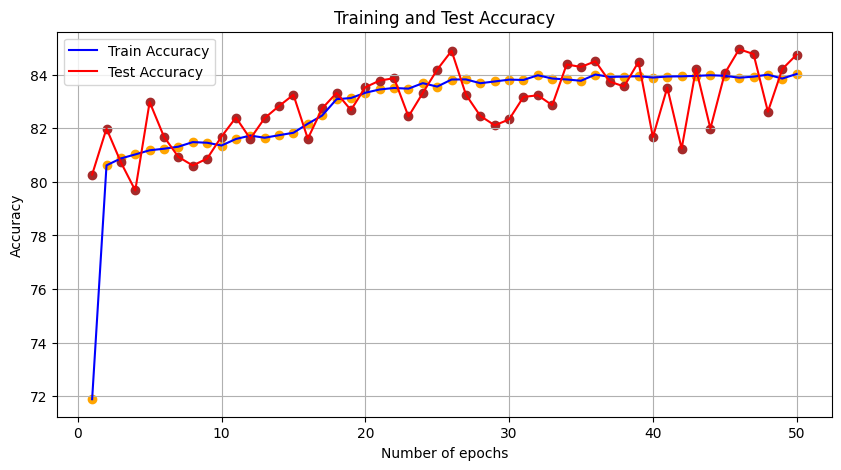

In [215]:
fig = plt.figure(figsize= (10, 5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.scatter(epochs, train_accuracies, color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.scatter(epochs, test_accuracies, color='brown')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid(visible=True)
plt.show()

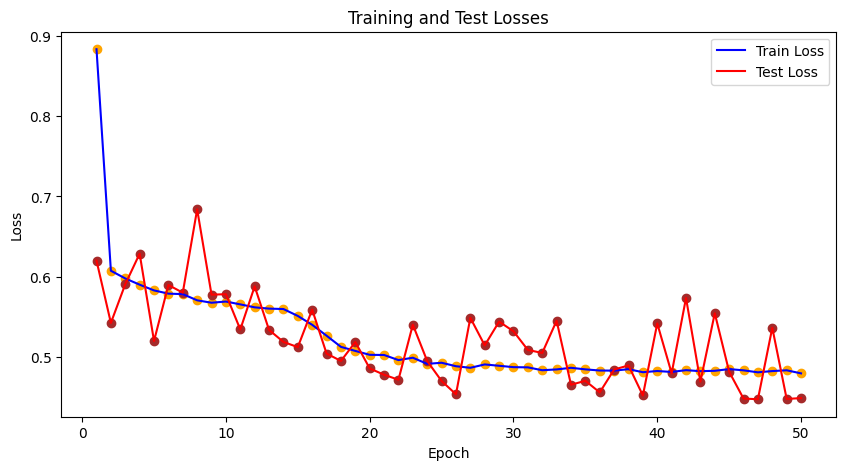

In [216]:
# Plotting train and test losses
plt.figure(figsize=(10, 5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.scatter(epochs, train_losses, color='orange')
plt.plot(epochs, test_losses[1:], label='Test Loss', color='red')
plt.scatter(epochs, test_losses[1:], color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

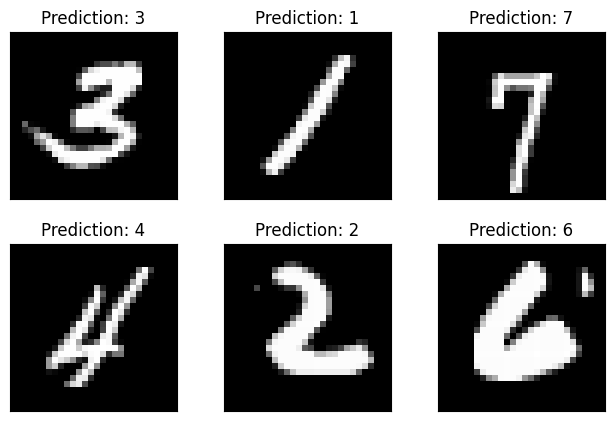

In [217]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [218]:
learning_rate = 0.01

optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

test()

test_accuracies = []
train_accuracies = []
train_losses = []
test_losses = []
train_counter = []
test_counter = []

for epoch in range(1, n_epochs + 1):
  train_accuracies.append(train(epoch))
  test_accuracies.append(test())

Test set: Average loss: 0.4487, Accuracy: 8475/10000 (84.75%)

Epoch 1 completed.
Train set: Average Loss: 0.428037, Accuracy: 85.38%
Test set: Average loss: 0.4049, Accuracy: 8584/10000 (85.84%)

Epoch 2 completed.
Train set: Average Loss: 0.421525, Accuracy: 85.53%
Test set: Average loss: 0.4038, Accuracy: 8582/10000 (85.82%)

Epoch 3 completed.
Train set: Average Loss: 0.419509, Accuracy: 85.58%
Test set: Average loss: 0.4033, Accuracy: 8581/10000 (85.81%)

Epoch 4 completed.
Train set: Average Loss: 0.418061, Accuracy: 85.60%
Test set: Average loss: 0.4046, Accuracy: 8572/10000 (85.72%)

Epoch 5 completed.
Train set: Average Loss: 0.417303, Accuracy: 85.57%
Test set: Average loss: 0.4008, Accuracy: 8581/10000 (85.81%)

Epoch 6 completed.
Train set: Average Loss: 0.416803, Accuracy: 85.65%
Test set: Average loss: 0.4032, Accuracy: 8572/10000 (85.72%)

Epoch 7 completed.
Train set: Average Loss: 0.415942, Accuracy: 85.62%
Test set: Average loss: 0.4027, Accuracy: 8574/10000 (85.74%)


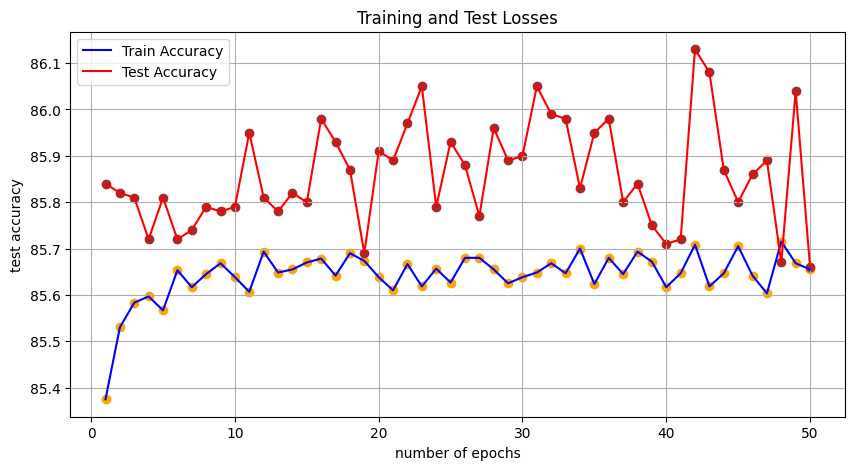

In [219]:
fig = plt.figure(figsize= (10, 5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.scatter(epochs, train_accuracies, color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.scatter(epochs, test_accuracies, color='brown')
plt.xlabel('number of epochs')
plt.ylabel('test accuracy')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(visible=True)
plt.show()

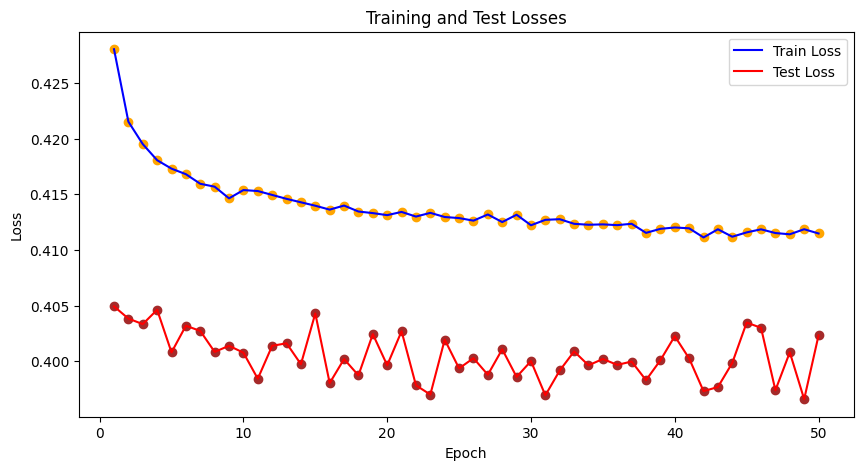

In [220]:
# Plotting train and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.scatter(epochs, train_losses, color='orange')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.scatter(epochs, test_losses, color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

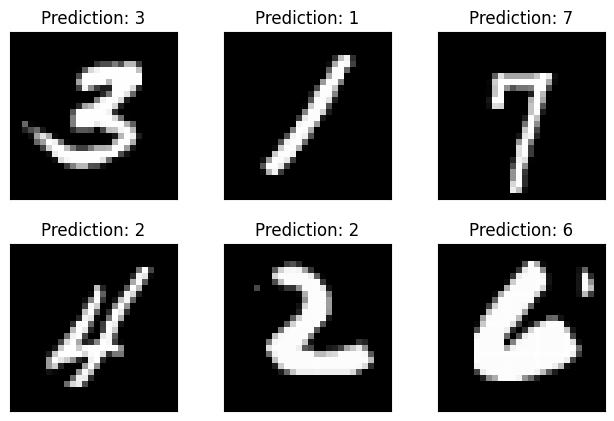

In [221]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [222]:
learning_rate = 0.001

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

test()

test_accuracies = []
train_accuracies = []
train_losses = []
test_losses = []
train_counter = []
test_counter = []

for epoch in range(1, n_epochs + 1):
  train_accuracies.append(train(epoch))
  test_accuracies.append(test())

Test set: Average loss: 2.3077, Accuracy: 1135/10000 (11.35%)

Epoch 1 completed.
Train set: Average Loss: 2.295839, Accuracy: 11.10%
Test set: Average loss: 2.2806, Accuracy: 1178/10000 (11.78%)

Epoch 2 completed.
Train set: Average Loss: 2.261949, Accuracy: 14.82%
Test set: Average loss: 2.2291, Accuracy: 2040/10000 (20.40%)

Epoch 3 completed.
Train set: Average Loss: 2.135279, Accuracy: 28.72%
Test set: Average loss: 2.0066, Accuracy: 3754/10000 (37.54%)

Epoch 4 completed.
Train set: Average Loss: 1.806984, Accuracy: 42.99%
Test set: Average loss: 1.5851, Accuracy: 4809/10000 (48.09%)

Epoch 5 completed.
Train set: Average Loss: 1.466985, Accuracy: 52.20%
Test set: Average loss: 1.3468, Accuracy: 5652/10000 (56.52%)

Epoch 6 completed.
Train set: Average Loss: 1.295113, Accuracy: 57.77%
Test set: Average loss: 1.2167, Accuracy: 5956/10000 (59.56%)

Epoch 7 completed.
Train set: Average Loss: 1.196075, Accuracy: 60.42%
Test set: Average loss: 1.1416, Accuracy: 6183/10000 (61.83%)


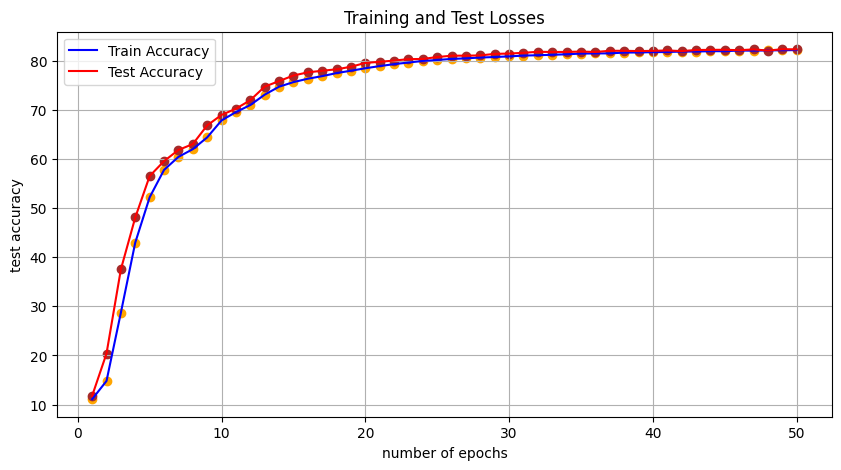

In [223]:
fig = plt.figure(figsize= (10, 5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.scatter(epochs, train_accuracies, color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.scatter(epochs, test_accuracies, color='brown')
plt.xlabel('number of epochs')
plt.ylabel('test accuracy')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(visible=True)
plt.show()

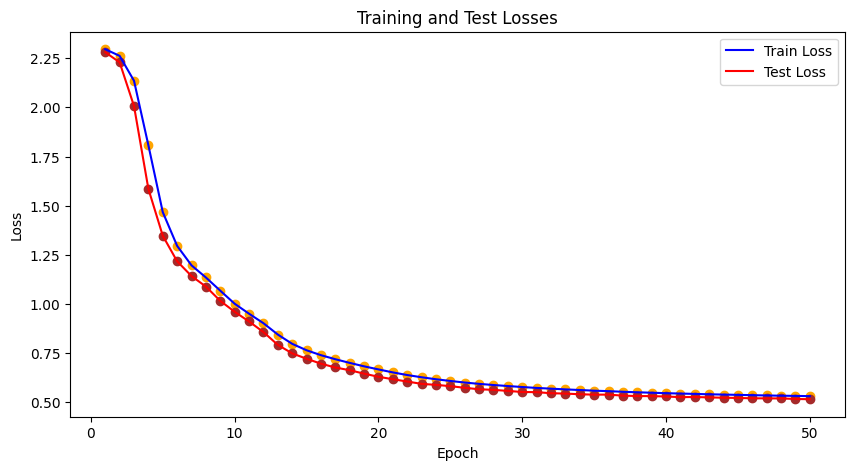

In [224]:
# Plotting train and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.scatter(epochs, train_losses, color='orange')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.scatter(epochs, test_losses, color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

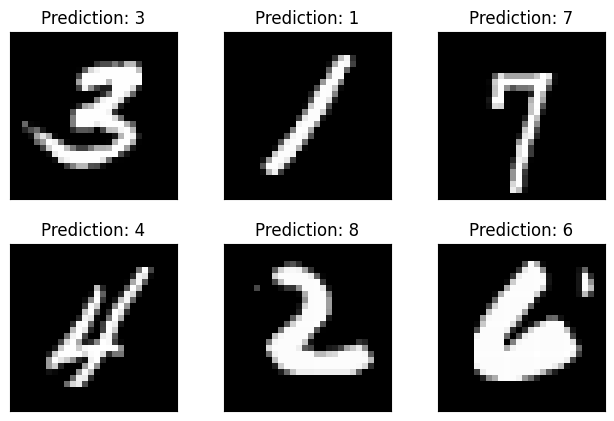

In [225]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [246]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [247]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,momentum=momentum)

In [248]:
test_accuracies = []
train_accuracies = []
train_losses = []
test_losses = []
train_counter = []
test_counter = []

for epoch in range(1, n_epochs + 1):
  train_accuracies.append(train(epoch))
  test_accuracies.append(test())

C:\Users\ibpri\AppData\Local\Temp\ipykernel_12792\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 1 completed.
Train set: Average Loss: 0.921909, Accuracy: 68.97%
Test set: Average loss: 0.2109, Accuracy: 9407/10000 (94.07%)

Epoch 2 completed.
Train set: Average Loss: 0.386358, Accuracy: 88.41%
Test set: Average loss: 0.1258, Accuracy: 9613/10000 (96.13%)

Epoch 3 completed.
Train set: Average Loss: 0.303380, Accuracy: 90.94%
Test set: Average loss: 0.1011, Accuracy: 9687/10000 (96.87%)

Epoch 4 completed.
Train set: Average Loss: 0.259377, Accuracy: 92.33%
Test set: Average loss: 0.0857, Accuracy: 9718/10000 (97.18%)

Epoch 5 completed.
Train set: Average Loss: 0.234912, Accuracy: 93.07%
Test set: Average loss: 0.0746, Accuracy: 9765/10000 (97.65%)

Epoch 6 completed.
Train set: Average Loss: 0.218089, Accuracy: 93.67%
Test set: Average loss: 0.0689, Accuracy: 9776/10000 (97.76%)

Epoch 7 completed.
Train set: Average Loss: 0.198124, Accuracy: 94.30%
Test set: Average loss: 0.0645, Accuracy: 9799/10000 (97.99%)

Epoch 8 completed.
Train set: Average Loss: 0.186595, Accuracy

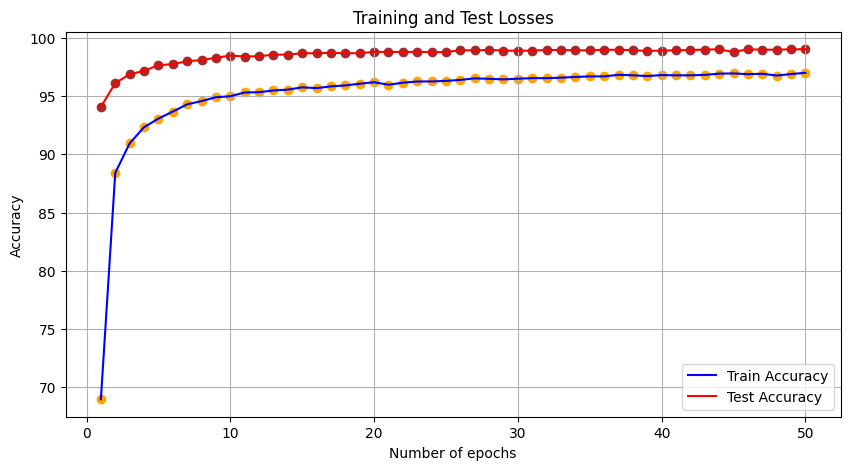

In [249]:
fig = plt.figure(figsize= (10, 5))
epochs = range(1, n_epochs+1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.scatter(epochs, train_accuracies, color='orange')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.scatter(epochs, test_accuracies, color='brown')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Losses')
plt.legend()
plt.grid(visible=True)
plt.show()

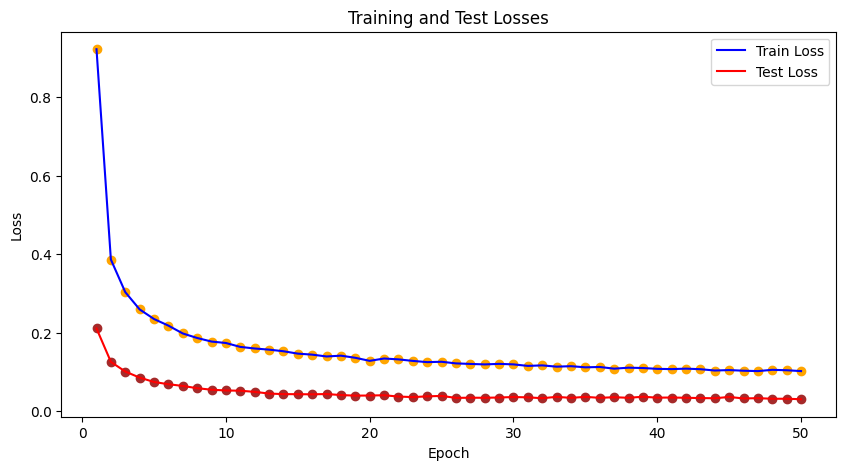

In [250]:
# Plotting train and test losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.scatter(epochs, train_losses, color='orange')
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.scatter(epochs, test_losses, color='brown')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

C:\Users\ibpri\AppData\Local\Temp\ipykernel_12792\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


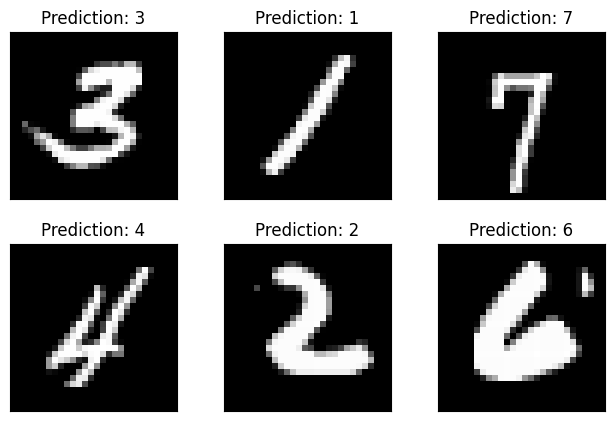

In [251]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [253]:
summary(network, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


C:\Users\ibpri\AppData\Local\Temp\ipykernel_12792\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
